In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/onlineretail/OnlineRetail.csv


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("/kaggle/input/onlineretail/OnlineRetail.csv", encoding="ISO-8859-1")


In [4]:
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [7]:
df = df[df['Quantity'] > 0]

In [8]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [9]:
import datetime as dt

# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reference date (1 day after last invoice date)
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [10]:
# Step 5: Create RFM Table
# ----------------------------
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'      # Monetary
}).reset_index()

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

In [11]:
# Step 6: RFM Scoring
# ----------------------------
quantiles = rfm.quantile(q=[0.25,0.5,0.75]).to_dict()

def r_score(x):
    if x <= quantiles['Recency'][0.25]:
        return 4
    elif x <= quantiles['Recency'][0.50]:
        return 3
    elif x <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1

def fm_score(x, col):
    if x <= quantiles[col][0.25]:
        return 1
    elif x <= quantiles[col][0.50]:
        return 2
    elif x <= quantiles[col][0.75]:
        return 3
    else:
        return 4

rfm['R'] = rfm['Recency'].apply(r_score)
rfm['F'] = rfm['Frequency'].apply(fm_score, col='Frequency')
rfm['M'] = rfm['Monetary'].apply(fm_score, col='Monetary')

rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)


In [12]:
# Step 7: Segmentation
# ----------------------------
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Best Customers'
    elif df['RFM_Score'] >= 6:
        return 'Loyal Customers'
    elif df['RFM_Score'] >= 4:
        return 'At Risk'
    else:
        return 'Low-Value'

rfm['Segment'] = rfm.apply(segment_me, axis=1)

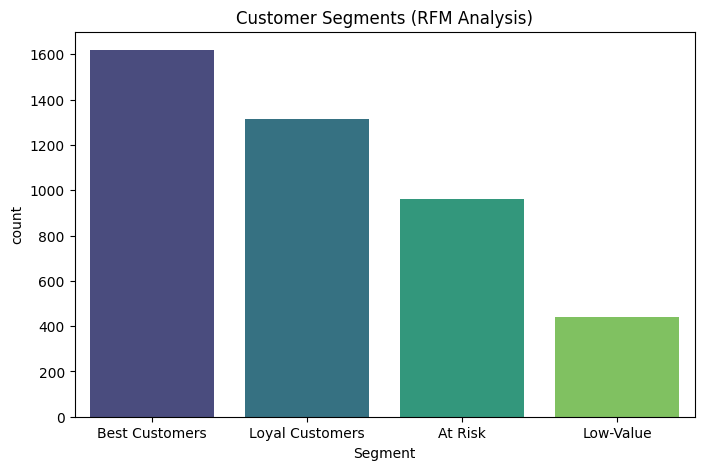

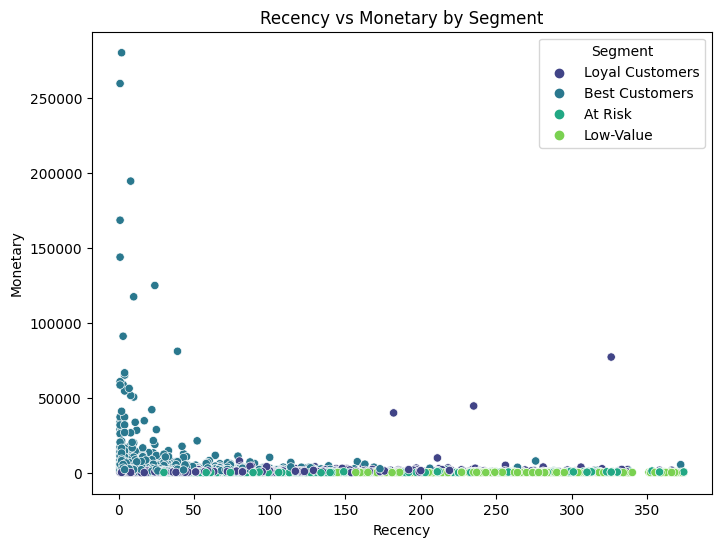

In [13]:
# Step 8: Visualization
# ----------------------------
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments (RFM Analysis)")
plt.show()

# Recency vs Monetary scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x='Recency', y='Monetary', hue='Segment', data=rfm, palette="viridis")
plt.title("Recency vs Monetary by Segment")
plt.show()

In [14]:
# Step 9: Insights
# ----------------------------
print(rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Num_Customers'}))

                    Recency  Frequency     Monetary  Num_Customers
Segment                                                           
At Risk          148.216216   1.237006   335.318265            962
Best Customers    24.688079   8.571958  4538.071001           1619
Low-Value        267.282805   1.000000   165.025452            442
Loyal Customers   76.553191   2.299392   888.110587           1316
